In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import missingno as msno

Data Attributes

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter ‘c’, it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

--2022-03-03 14:07:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23715344 (23M) [application/x-httpd-php]
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx  100%[===================>]  22.62M  10.7MB/s    in 2.1s    

2022-03-03 14:07:59 (10.7 MB/s) - ‘Online Retail.xlsx’ saved [23715344/23715344]



### Part I - Data Loading & Cleaning

In [3]:
df = pd.read_excel('/content/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


There are total 541,909 records, some customer id's are missing along with few stock descriptions. 

In [5]:
# Convert data types
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  Int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  Float64       
 6   CustomerID   406829 non-null  Int64         
 7   Country      541909 non-null  string        
dtypes: Float64(1), Int64(2), datetime64[ns](1), object(3), string(1)
memory usage: 34.6+ MB


Visualizing missing info

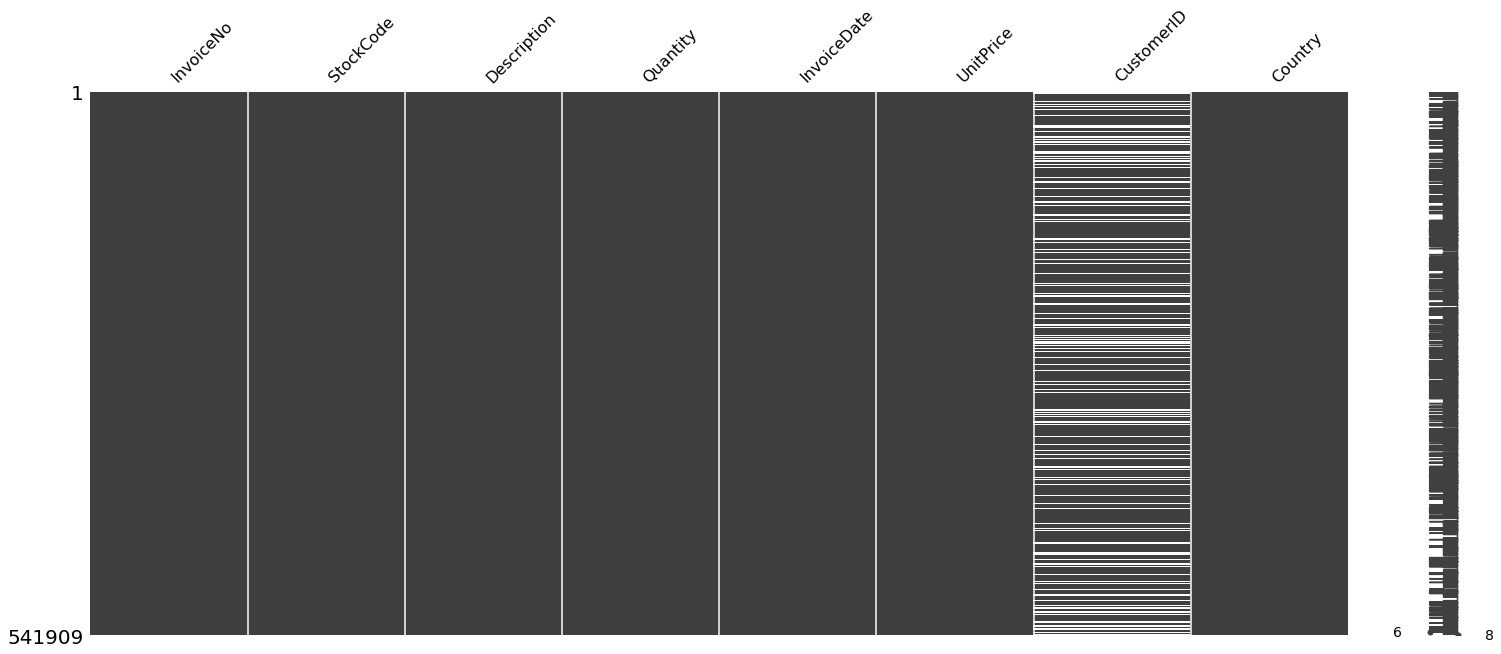

In [6]:
import missingno as msno

msno.matrix(df)
plt.show()

There are about 500 product descriptions missing and many customer ids are missing from the data. Before we go and anlyze missing customer info, let's calculate the total sales by multiplying quantity with unit price. 

In [7]:
# Total sales
df = df.assign(
    sales = lambda x: x.Quantity * x.UnitPrice
)

print("Total sales: {:.2f}".format(df.sales.sum()))

Total sales: 9747747.93


In [8]:
# Identify duplicate entries if any
df.duplicated().sum()

5268

There are 5268 duplicate transactions in the data. Assuming these are errors from data extraction process, however, this typically need to be validated with source system to verify if they are real transactions or duplicated rows due to data extraction and loding processes. 

Now, we will check the inflated transaction amount. 

In [9]:
df.loc[df.duplicated()].sales.sum()

21740.98

Revenue is inflated by about 22K. Here we can delete based on assumption that they are duplicates resulting from data generation/extraction processes.

In [10]:
# we use ~ symbol to remove the duplicated rows from the dataset.
df = df.loc[~df.duplicated()]
df.sales.sum()

9726006.953999998

In [11]:
# Verify total Sales from unidentified/missing customer ids i.e guests
sales_guests = df.loc[df.CustomerID.isnull()].sales.sum()

print("Sales from guest customers: {:.2f}".format(sales_guests))

Sales from guest customers: 1447487.53


In [12]:
# Calculate total sales of identified customers
sales_registered_clients = df.loc[df.CustomerID.notnull()].sales.sum()
print("Sales from registered clients: {:.2f}".format(sales_registered_clients))

Sales from registered clients: 8278519.42


In [13]:
# number of records with zero sales
zero_sales = df.loc[df.sales.eq(0)]
zero_sales.count()

InvoiceNo      2510
StockCode      2510
Description    1056
Quantity       2510
InvoiceDate    2510
UnitPrice      2510
CustomerID       40
Country        2510
sales          2510
dtype: int64

There are 2510 records with no sales, only 40 of them are registered customers. We can remove these transactions as they don't contribute to the further analysis.

In [14]:
# filtering no sale records
df = df.loc[df.sales.ne(0)] # ne = not equal
print(df.shape)

# cross validating total sales. 
print("Total sales: {:.2f}".format(df.sales.sum()))

(534131, 9)
Total sales: 9726006.95


We have 534,131  records left, and total sales remains the same (9,726,006.95)

Now we would look at descriptive statistics

In [15]:
df.reset_index(drop=True, inplace=True)
df.CustomerID = df.CustomerID.astype(str)
df.describe()

,Quantity,UnitPrice,sales
count,534131.000000,534131.000000,534131.000000
mean,9.916784,4.654426,18.209029
std,216.451709,97.460790,381.547578
min,-80995.000000,-11062.060000,-168469.600000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.100000,9.900000
75%,10.000000,4.130000,17.570000
max,80995.000000,38970.000000,168469.600000


We can see that maximum and minimum sales trasactions can be seen as  return of merchandise from a single customer. Removing these transactions would help remove the skew in summary statistics.

In [16]:
netzero_sales = df[df.groupby(['CustomerID','StockCode'])['sales'].transform('sum').eq(0)]

netzero_sales.sort_values(by=['StockCode','CustomerID'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sales
243235,558714,10133,COLOURING PENCILS BROWN TUBE,10,2011-07-01 13:17:00,0.42,17888,United Kingdom,4.2
243254,C558716,10133,COLOURING PENCILS BROWN TUBE,-10,2011-07-01 13:22:00,0.42,17888,United Kingdom,-4.2
366373,569214,15034,PAPER POCKET TRAVELING FAN,1200,2011-10-02 12:22:00,0.07,14533,United Kingdom,84.0
372531,C569552,15034,PAPER POCKET TRAVELING FAN,-1200,2011-10-04 17:44:00,0.07,14533,United Kingdom,-84.0
240977,558533,15036,ASSORTED COLOURS SILK FAN,24,2011-06-30 11:49:00,0.83,16717,United Kingdom,19.92
...,...,...,...,...,...,...,...,...,...
191394,C553560,M,Manual,-1,2011-05-17 17:14:00,293.0,14931,Channel Islands,-293.0
179781,552549,M,Manual,1,2011-05-10 10:39:00,334.71,15674,United Kingdom,334.71
179818,C552553,M,Manual,-1,2011-05-10 10:51:00,334.71,15674,United Kingdom,-334.71
170694,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029,United Kingdom,-8142.75


In [17]:
# total number of transactions along with returns
netzero_sales.shape

(3044, 9)

In [18]:
# Cross validating the result
netzero_sales.sales.sum().round()

-0.0

Clean netzero sale transactions

In [19]:
print(df.shape)
df = df[~df.groupby(['CustomerID','StockCode'])['sales'].transform('sum').eq(0)]
print(df.shape)

(534131, 9)
(531087, 9)


We can confirm the removal of 3044 purchases and returns identified. Again we check the descriptive statistics

In [20]:
df.describe()

,Quantity,UnitPrice,sales
count,531087.000000,531087.000000,531087.000000
mean,9.973624,4.539735,18.313397
std,40.713949,95.669873,128.834851
min,-9360.000000,-11062.060000,-38970.000000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.100000,9.900000
75%,10.000000,4.130000,17.700000
max,4800.000000,38970.000000,38970.000000


We can peek into transactions corresponds to 38,970 sale transaction and corresponding return. 

In [21]:
df[df.sales.eq(38970.000000) | df.sales.eq(-38970.000000)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sales
219468,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom,38970.0
219469,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098,United Kingdom,-38970.0


In [22]:
df[df.CustomerID == '15098']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,sales
219458,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
219468,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098,United Kingdom,38970.0
219469,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.0,15098,United Kingdom,-38970.0
219470,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098,United Kingdom,649.5
219480,C556448,22502,PICNIC BASKET WICKER SMALL,-60,2011-06-10 15:39:00,4.95,15098,United Kingdom,-297.0


As expected we can see that these are errors and a correction done manually. Customer actually paid 649.5. Since we removed net zero sale transactions using combination of stock code and customer id, these transactions are not removed by group by filtering criteria.

Now we would remove the transactions that net to zero at the customer level. 



In [23]:
print(df.shape)
df = df[~df.groupby(['CustomerID'])['sales'].transform('sum').eq(0)]
print(df.shape)

(531087, 9)
(531077, 9)


After the above step, we can safely assume that remaining return transactions would be partial returns where net sales amount would be positive value or zero if stock codes mismatch when customer returns the merchandise or due to manual adjustments. As the sales netted to zero, these transactions don't affect the customer life time value estimates down the road. However, returns with missing customer identification can be problematic, as all missing customer transactions are lumped into single group. 

There are some product codes that are not actual products, but can be considered as cost of saless such ; 
* Fees paid to Amazon
* Bad debt adjustment possibly the result of delinquncy on purchase made by retailer issued credit 
* Bank charges paid by the retailer
* Optional donation elected by customers to Cancer Research UK (CRUK).
* Postage charges/DOTCOM POSTAGE- some cases retailer may have offered free shipping and other cases customers have paid for the postage. Total postage amount is positive

Excluding donations to CRUK, the remaining trasactions partially paid by customers but net amount is negative adjustment to sales, which turned out to be cost of sales of about $185K.

Generally we would allocate these costs to customers based on worked out allocation strategy such as customer lifetime value. But we are not pursuing this route for this analysis. 

Therefore we remove these transactions for further analysis, where customer is not directly associated with the transaction.

In [28]:
cost_codes = ['AMAZONFEE','B','POST','DOT','CRUK','BANK CHARGES','S']

misc_sales = df.loc[(df.StockCode.isin(cost_codes)) & \
                       (df.CustomerID == '<NA>')]
misc_sales.sales.sum()

-49103.33

In [29]:
# removing the misc. sales from the cost codes stated above
print(df.shape)
df = df.loc[~((df.StockCode.isin(cost_codes)) & \
            (df.CustomerID == '<NA>'))]
print(df.shape)

(531077, 9)
(530206, 9)


We can remove remaining trasactions with no customer ids when we look for metrics per customer such as average sales per customer. But for now we proceed with 530,206 records for further descriptive analysis. 

# Part II Descriptive Analysis

### What is the weekly sales trend looks like?

In [30]:
df.set_index('InvoiceDate',inplace=True)

In [31]:
weekly_sales = df.resample('W').sum()

In [32]:
weekly_sales.head()

,Quantity,UnitPrice,sales
InvoiceDate,,,
2010-12-05,79563,35172.39,177809.65
2010-12-12,119138,65285.21,297190.87
2010-12-19,104474,44462.14,201178.15
2010-12-26,38309,21343.49,84753.69
2011-01-02,0,0.0,0.0


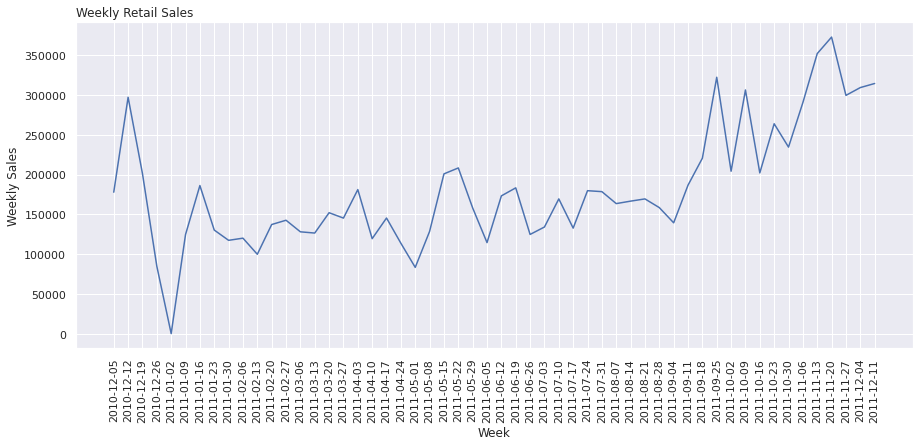

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
sns.set()
sns.lineplot(x=weekly_sales.index, y='sales', data=weekly_sales)

plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Weekly Retail Sales', loc='left')
plt.xticks(ticks=weekly_sales.index, rotation=90)
plt.show()

We can see from the above graph that w:eekly sales are trending up

### How many days are without sale transactions?




In [34]:
daily_sales = df.resample('D').sum()

zero_sales = daily_sales[daily_sales.sales == 0]
print(zero_sales.count())

Quantity     69
UnitPrice    69
sales        69
dtype: int64


There are no sales for 69 days in the sampling period (54 weeks)

### What is the order value by month?

In [35]:
# we have used resampling earlier, here we use a different approach
sales_by_month = df.groupby(pd.Grouper(freq='M')).agg({
    'sales':'sum'}
)

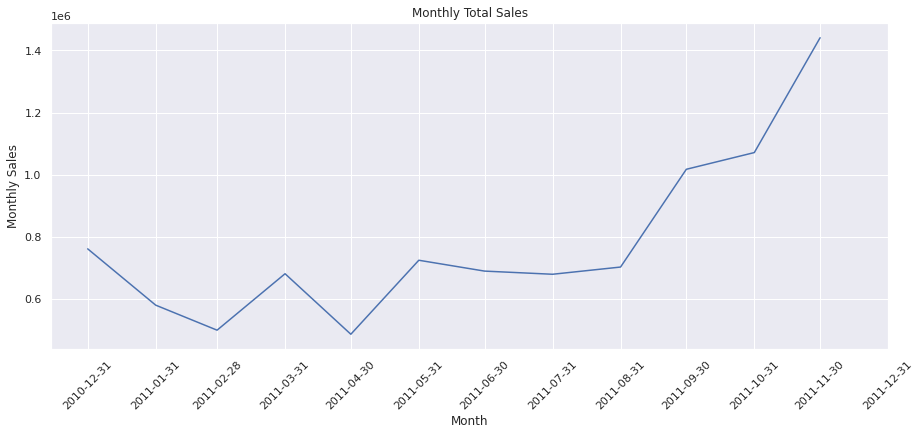

In [36]:
plt.figure(figsize=(15,6))
sns.set()

sns.lineplot(x=sales_by_month.index[:-1], y=sales_by_month.sales[:-1])

plt.xlabel('Month')
plt.ylabel('Monthly Sales')
plt.title('Monthly Total Sales', loc='center')
plt.xticks(ticks=sales_by_month.index, rotation=45)
plt.show()

Monthly sales are flat until August, 2011 - then started moving up

### What are the top 10 countries by sales?

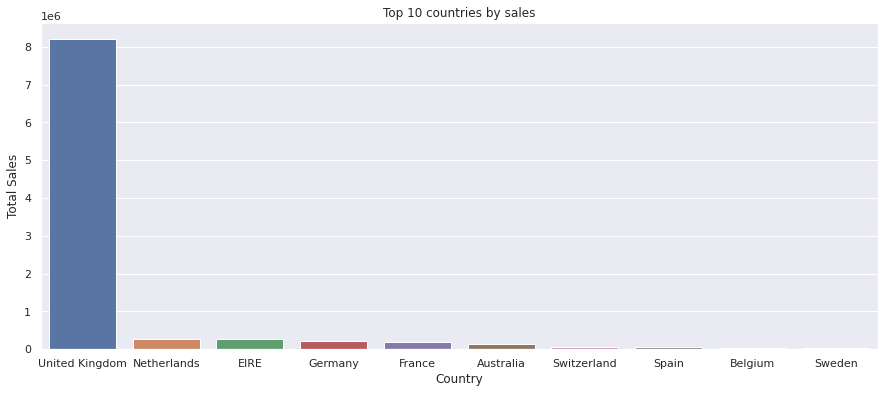

In [37]:
sales_by_country = df.groupby(by='Country')[['sales']] \
                        .agg({'sales':'sum'}) \
                        .reset_index() \
                        .sort_values(by='sales', ascending=False).head(10)

plt.figure(figsize=(15,6))
sns.set()
sns.barplot(x='Country', y='sales', data=sales_by_country)

plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Top 10 countries by sales', loc='center')
plt.show()

United Kingdom is the largest driver of sales geographically

### What is my revenue breakdown by product?

In [38]:
sales_by_product = df.groupby(['StockCode','Description'])['sales'] \
                        .sum()\
                        .reset_index()\
                        .sort_values(by='sales', ascending=False).head(10)

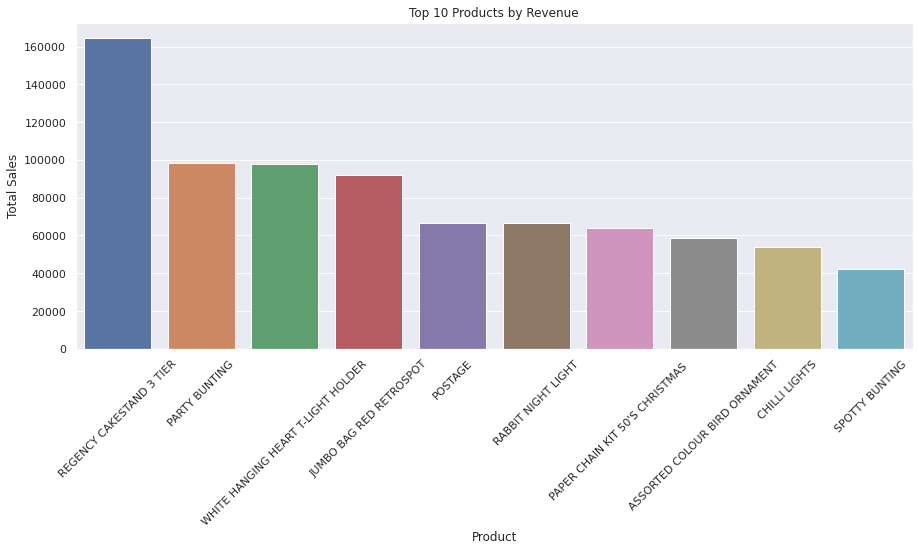

In [39]:
plt.figure(figsize=(15,6))
sns.set()
sns.barplot(x='Description', y='sales', data=sales_by_product)

plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.title('Top 10 Products by Revenue', loc='center')
plt.xticks(rotation=45)
plt.show()

In [40]:
sales_by_product

,StockCode,Description,sales
1262,22423,REGENCY CAKESTAND 3 TIER,164459.49
2669,47566,PARTY BUNTING,98243.88
3782,85123A,WHITE HANGING HEART T-LIGHT HOLDER,97659.94
3770,85099B,JUMBO BAG RED RETROSPOT,92175.79
4162,POST,POSTAGE,66710.24
1950,23084,RABBIT NIGHT LIGHT,66661.63
945,22086,PAPER CHAIN KIT 50'S CHRISTMAS,63715.24
2877,84879,ASSORTED COLOUR BIRD ORNAMENT,58792.42
2738,79321,CHILLI LIGHTS,53746.66
2206,23298,SPOTTY BUNTING,42030.67


Interestingly, while postage is not an actual product revenue collected from postage ranks 6th which is net amount after taking out shipping charges paid by retailer. Earlier we have removed the misc. revenue charges that are not associated with a custoemer.

#### Weekly Sales by Customer

For doing sales by customer analysis - we would need to remove the sales transactions that are not associated with a customer. 

In [43]:
# create a new dataframe excluding transactions with a guests
df_cust = df.loc[(df.CustomerID != '<NA>')]

For calculating average weekly sales by customer, we would need total sales and number of unique customer for that week. Simple mean aggregation would give incorrect result as count is used for calculating average sales.

In [44]:

avg_weekly_sales_cust = df_cust.groupby([pd.Grouper(freq='W')]).agg(
    {
        'CustomerID':'nunique',
        'sales':'sum'
    }
)

In [45]:
avg_weekly_sales_cust.rename(columns={'CustomerID':'n_customers'}, inplace=True)

avg_weekly_sales_cust = avg_weekly_sales_cust.assign(
    avg_weekly_cust = lambda x: x.sales.div(x.n_customers)
)


In [46]:
avg_weekly_sales_cust.head()

,n_customers,sales,avg_weekly_cust
InvoiceDate,,,
2010-12-05,323,144706.89,448.008947
2010-12-12,446,207160.52,464.485471
2010-12-19,380,155558.09,409.363395
2010-12-26,121,43456.97,359.148512
2011-01-02,0,0.0,NaN


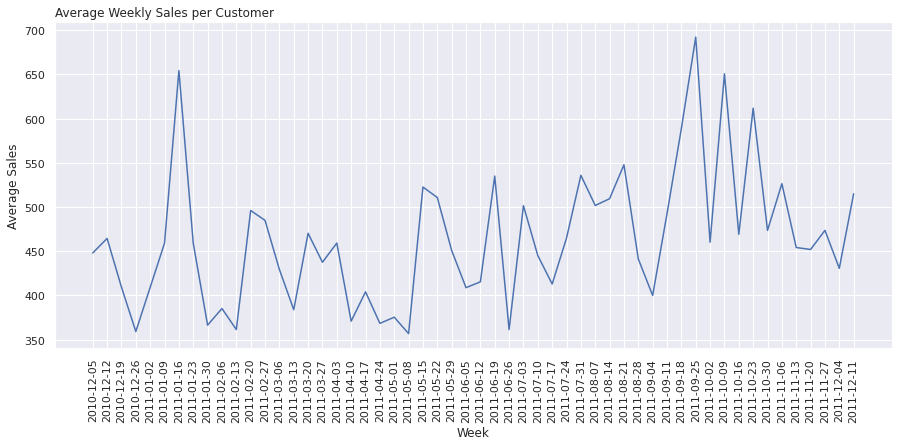

In [47]:
plt.figure(figsize=(15,6))
sns.set()

sns.lineplot(x=avg_weekly_sales_cust.index, y='avg_weekly_cust',
             data=avg_weekly_sales_cust)
plt.xlabel('Week')
plt.ylabel('Average Sales')
plt.title('Average Weekly Sales per Customer', loc='left')
plt.xticks(ticks=avg_weekly_sales_cust.index, rotation=90)
plt.show()

### Cohort Analysis
Perform Cohort Analysis
Cohort analysis is a type of behavior analysis to identify shared patterns of groups of users as opposed to individuals. This type of analysis by cohorts enables analyst to ask specific questions that leads to better product/service decisions to improve customer retention and increase revenue.

The cohort analysis begins by identifying the joining date or first purchase date of the customer as basis creating a cohort of customers. 

In [48]:
df_cust.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,sales
InvoiceDate,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.3
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.0
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34


To begin cohort analysis, we need to maninupate the invoice date column to get order month and identify the month in which each customer made first transaction. We use this info to group customers into cohorts based on the month of their first purchase event.

In [49]:
df_cust.reset_index(inplace=True)
df_cust = df_cust.assign(
               order_month = lambda x: x.InvoiceDate.dt.to_period('M'),
               cohort = df_cust.groupby(by='CustomerID')['InvoiceDate'] \
                          .transform('min').dt.to_period('M')
      )

In [50]:
df_cust.head()

,InvoiceDate,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,sales,order_month,cohort
0,2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.3,2010-12,2010-12
1,2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,2010-12,2010-12
2,2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.0,2010-12,2010-12
3,2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,2010-12,2010-12
4,2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,2010-12,2010-12


Below we calculate the number of unique customers for a given order month and cohort

In [51]:
cohort = df_cust.groupby(by=['cohort','order_month'])\
           .agg(n_customers=('CustomerID', 'nunique'))\
           .reset_index()

Calculate the period in months by subtracting cohort month from order month.

In [52]:
cohort = cohort.assign(
    period = lambda x: (x.order_month.dt.year - x.cohort.dt.year) * 12 + 
                       (x.order_month.dt.month - x.cohort.dt.month)
                      )


In [53]:
cohort_pt = cohort.pivot_table(values='n_customers', index='cohort', columns='period')

Calculate customer retention matrix by diving with cohort size in the first period.

In [54]:
cohort_size = cohort_pt[0] # number of unique customers in the first month
retention_matrix = cohort_pt.div(cohort_size, axis=0)
retention_matrix

period,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.380148,0.333685,0.384372,0.354805,0.395987,0.378036,0.351637,0.354805,0.391763,0.371700,0.497360,0.274551
2011-01,1.0,0.232779,0.282660,0.244656,0.327791,0.296912,0.258907,0.251781,0.308789,0.346793,0.368171,0.147268,NaN
2011-02,1.0,0.247368,0.189474,0.278947,0.268421,0.244737,0.252632,0.278947,0.255263,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.177273,0.252273,0.218182,0.231818,0.177273,0.261364,0.236364,0.286364,0.088636,NaN,NaN,NaN
2011-04,1.0,0.224080,0.217391,0.207358,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.223827,0.173285,0.169675,0.216606,0.238267,0.267148,0.101083,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.196581,0.188034,0.273504,0.243590,0.333333,0.102564,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.200000,0.205263,0.226316,0.268421,0.115789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.233533,0.245509,0.239521,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plotting retention matrix

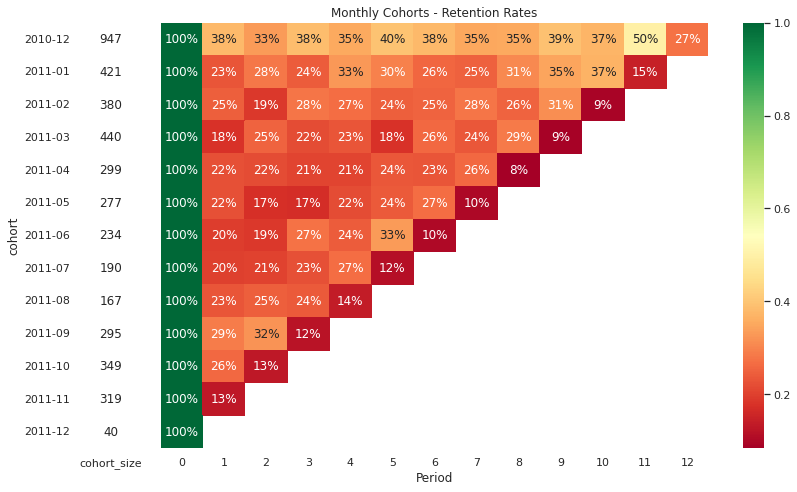

In [55]:
with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2, figsize=(12, 7), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # plotting retention rates
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(),
                annot=True, 
                fmt = '.0%',
                cmap='RdYlGn',
                ax = ax[1])
    
    ax[1].set_title("Monthly Cohorts - Retention Rates")
    ax[1].set(xlabel = "Period",ylabel='')
    
    cohort_size = pd.DataFrame(cohort_pt[0]).rename(columns={0:'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    
    # plotting cohort size
    sns.heatmap(cohort_size, 
                annot = True,
                fmt = 'g',
                cbar = False,
                cmap = white_cmap,
                ax = ax[0])
    
    fig.tight_layout()

In the period 0 and down - we can see 38% retention rate for the Dec, 2020 cohort compared to 23% retention rate for the Jan, 2011 cohort. 

On the horizontal axis provides insight into life cycle of customers in the cohort. For the Dec, 2020 cohort, an average retention rate of 37% observed with the exception of 50% retention rate observed in period 11. 

Cohort retention rate matrix provides dynamic view of customer retention rates or churn rates on monthly basis. This helps to craft marketing plan and commonication strategies for the cohorts with lower retention rate in conjunction with customer life time value analysis.

### Calculate retention rate

In [56]:
retention_rate = retention_matrix.iloc[:,1:].mean().mean()
print("Retention rate: {}%".format(np.round(retention_rate * 100, 2)))  

Retention rate: 26.0%


### Calculate churn rate

In [57]:
churn_matrix =  1 - retention_matrix
churn_rate = churn_matrix.iloc[:,1:].mean().mean()
print("Churn rate: {}%".format(np.round(churn_rate * 100, 2)))  

Churn rate: 74.0%


### Calculate Customer Life Time Value

Basic CLV Calculation

In [58]:
# Basic LTV = avg monthly income * customer life cycle
df_cust.set_index('InvoiceDate', inplace=True)
avg_monthly_income = df_cust.groupby(by=['CustomerID', pd.Grouper(freq='M')])['sales'].sum().mean()
life_cycle =  12

basic_ltv = avg_monthly_income * life_cycle
print("Basic CLV: {:.2f} USD".format(basic_ltv))

Basic CLV: 7316.41 USD


Traditional CLV Calculaton

In [59]:
# Traditional LTV = monthly revenue * retention rate / churn rate

avg_monthly_income = df_cust.groupby(by=['CustomerID', pd.Grouper(freq='M')])['sales'].sum().mean()

traditional_ltv =  avg_monthly_income * retention_rate/churn_rate

print("Average Tradional CLV: {:.2f} USD at retention rate of {:.2f} %".\
                              format(traditional_ltv, retention_rate*100))

print("Monthly Average Revenue: {:.2f} USD".format(avg_monthly_income))

Average Tradional CLV: 214.24 USD at retention rate of 26.00 %
Monthly Average Revenue: 609.70 USD


Granular CLV Calculation

In [60]:
# Granular LTV = avg order value x avg order frequency x customer life cycle

avg_order_value = df.groupby(['InvoiceNo'])['sales'].mean().mean()
avg_order_frequency = df.groupby(['CustomerID', pd.Grouper(freq='M')])['InvoiceNo'].nunique().mean()
life_cycle = 12

granular_ltv = avg_order_value  * avg_order_frequency * life_cycle

print("Average Granular CLV: {:.2f} USD".format(granular_ltv))
print("Monthly Average Order Value: {:.2f} USD".format(avg_order_value))
print("Monthly Average Order Frequency: {}".format(avg_order_frequency))

Average Granular CLV: 693.55 USD
Monthly Average Order Value: 33.84 USD
Monthly Average Order Frequency: 1.7078949304686926


# Rule-based clustering using RFM features

In [61]:
df_cust.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,sales,order_month,cohort
InvoiceDate,,,,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,15.3,2010-12,2010-12
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,20.34,2010-12,2010-12
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,22.0,2010-12,2010-12
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,20.34,2010-12,2010-12
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,20.34,2010-12,2010-12


In [62]:
import datetime as dt
latest_date = df_cust.index.max() + dt.timedelta(1)
sales = df_cust.assign(recency = lambda x: x.index)

sales.recency = sales.recency.dt.date

features = sales.groupby(by='CustomerID').agg({
                        'recency': lambda x: (latest_date - x.index.max()).days,
                        'InvoiceNo': 'nunique',
                        'sales': 'sum',
                        'Quantity': ['mean','sum']
                        }
                       ).reset_index()

features.columns = ['CustomerID','recency','frequency', 'monetary','quantity_avg','quantity_total']

In [63]:
features = features.sort_values(by='recency', ascending=True)
features.head()

,CustomerID,recency,frequency,monetary,quantity_avg,quantity_total
491,12985,1,2,1215.62,19.094595,1413
3680,17364,1,12,4437.23,6.530562,2671
3153,16626,1,20,4379.65,14.51087,2670
2090,15189,1,52,15802.14,26.23913,6035
936,13599,1,32,5026.85,12.326848,3168


In [64]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4358 entries, 491 to 1040
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      4358 non-null   object 
 1   recency         4358 non-null   int64  
 2   frequency       4358 non-null   int64  
 3   monetary        4358 non-null   Float64
 4   quantity_avg    4358 non-null   Float64
 5   quantity_total  4358 non-null   Int64  
dtypes: Float64(2), Int64(1), int64(2), object(1)
memory usage: 251.1+ KB


In [79]:

features = features.assign(log_recency = lambda x: np.log(x.recency + 1),
                           log_freq = lambda x: np.log(x.frequency + 1),
                           log_monetary = lambda x: np.log(x.monetary + 1))

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/numeric.py:203: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


In [80]:
features.shape

(4358, 14)

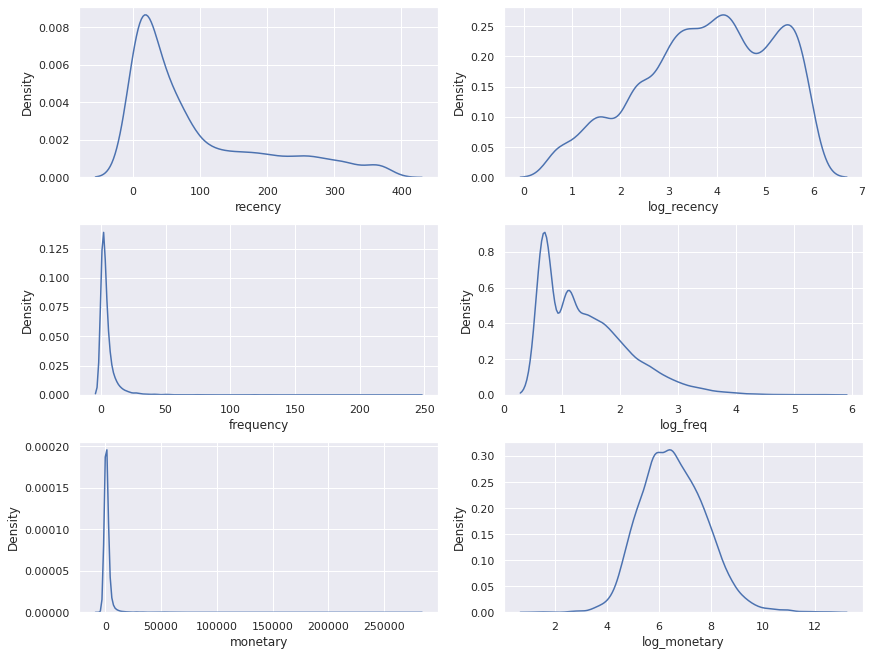

In [81]:
cols = ['recency','log_recency','frequency','log_freq','monetary','log_monetary']
n_plots = len(cols)
n_cols = 2
n_rows = n_plots // n_cols

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6*n_cols, 3*n_rows), 
                       constrained_layout=True)

for i, var in enumerate(cols):
  row = i // n_cols
  col = i % n_cols
  sns.kdeplot(x=var, data=features, ax=ax[row][col])
plt.show()

The distribution of the RFM features are all right skewed. Applying log transformation only changed the monetary feature to gaussian. Interestigly recency changed to left skewed after log transform. 

In [68]:
def rfm_ranks(df, var):
  """ returns series with rank of selected variable"""
  if var == 'recency':
    return np.where(df[var].le(df[var].quantile(0.25)), 4,
                         np.where(df[var].gt(df[var].quantile(0.25)) & df[var].le(df[var].quantile(0.5)), 3,
                         np.where(df[var].gt(df[var].quantile(0.5)) & df[var].le(df[var].quantile(0.75)), 2, 1)))

  elif var in ['frequency','monetary']:
    return np.where(df[var].le(df[var].quantile(0.25)), 1,
                         np.where(df[var].gt(df[var].quantile(0.25)) & df[var].le(df[var].quantile(0.5)), 2,
                         np.where(df[var].gt(df[var].quantile(0.5)) & df[var].le(df[var].quantile(0.75)), 3, 4)))


In [69]:
features['R'] = rfm_ranks(df=features, var='recency')
features['F'] = rfm_ranks(df=features, var='frequency')
features['M'] = rfm_ranks(df=features, var='monetary')

In [70]:
features = features.assign(score = lambda x: (x.R + x.F + x.M)/3)

In [71]:
membership = {1: 'Bronze',2:'Silver', 3: 'Gold', 4:'Platinum'}

In [72]:
features.score = features.score.astype(int)
features = features.assign(member_type = features.score.map(membership))


In [78]:
features.groupby('member_type')[['recency','frequency','monetary','score']]\
        .agg('mean').sort_values(by='score',ascending=False)

,recency,frequency,monetary,score
member_type,,,,
Platinum,6.821138,18.709350,8826.733313,4.0
Gold,32.594177,6.612375,2319.95516,3.0
Silver,71.361749,2.535211,758.337941,2.0
Bronze,188.409027,1.279267,256.0917,1.0


The RFM scoring methodology is a rule based technique that may be used to target the current customers based on the identified behavior patterns. 

<b>Platinum</b> customers are most recently bought (in the last 7 days) the products from the retailer and most frequent buyers and spent an average amount of 8.8K. These are the most loyal customers and can be targeted for future promotions of new product sales for brand promotion. 

<b>Gold</b> customers recently bought products in the last 30 days with 7 purchases and spent an average amount of 2.3K. 
These customers may be targeted for the upselling/cross selling opportunities and offer loyalty programs to get them into plantinum tier. 

<b>Silver</b> customers recently bought products in the last quarter with average 3 purchases with average purchase value of 760.
These customers may be targeted by personalized messages, special offers, and product recommendations to re-engage these customers. 

<b>Bronze</b> these customers purchased 6 months ago and most likey churned, depending how business defines churn depends on product life they purchased. They may be targeted by sending relevant information with discount coupons, finding ways to get feedback on their purchases, experience with platform using survey to understand if there are any issues that can be addresed before losing them for good.  

